# Exploring format of Mozilla Common Voice (MCV)

# Merging clips and validated tsv

In [61]:
import pyaudio
import wave
import sys
import os
import random
import librosa
from IPython.display import Audio
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

MCV_dir = 'C:/Users/Jonah/Documents/Datasets/MCV/MCV_data/en'

Only using the "validated.tsv" as I want to ensure all of my audio has been verified.

In [62]:
val_df = pd.read_csv(MCV_dir + '/validated.tsv', sep='\t', low_memory=False)

val_df.head()

,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,000abb3006b78ea4c1144e55d9d158f05a9db011016051...,common_voice_en_27710027.mp3,b2cf0b3308b6e00b46f3e48fe59682452ae737a596aa29...,"Joe Keaton disapproved of films, and Buster al...",NaN,3,1,NaN,NaN,NaN,NaN,en,NaN
1,0013037a1d45cc33460806cc3f8ecee9d536c45639ba4c...,common_voice_en_699711.mp3,de9d68400821d73ee6868687d0562c60282ee9446d1191...,She'll be all right.,NaN,2,1,NaN,NaN,NaN,NaN,en,NaN
2,0014c5a3e5715a54855257779b89c2bb498d470b225866...,common_voice_en_21953345.mp3,14c0567a0a6c4ea49f2a1b2ac73de940b8c07779c70bf0...,six,NaN,3,2,NaN,NaN,NaN,NaN,en,Benchmark
3,001509f4624a7dee75247f6a8b642c4a0d09f8be3eeea6...,common_voice_en_18132047.mp3,db626d9888c3fbc71f1be862592c7831f27f275e199510...,All's well that ends well.,NaN,2,0,NaN,NaN,NaN,NaN,en,NaN
4,001519f234e04528a2b36158c205dbe61c8da45ab0242f...,common_voice_en_27340672.mp3,a975540ad0c7ceaaec94cd17ae3b55e1eaf89a61d4a579...,It is a busy market town that serves a large s...,NaN,2,0,NaN,NaN,NaN,NaN,en,NaN


In [63]:
duration_df = pd.read_csv(MCV_dir + '/clip_durations.tsv', sep='\t', low_memory=False)

duration_df.head()

,clip,duration[ms]
0,common_voice_en_542010.mp3,3024
1,common_voice_en_92137.mp3,3384
2,common_voice_en_18675557.mp3,6696
3,common_voice_en_19798775.mp3,6744
4,common_voice_en_17533881.mp3,7416


In [64]:
print('Shape of validated.tsv:', val_df.shape)
print('Shape of clip_durations.tsv:', duration_df.shape)

Shape of validated.tsv: (1812347, 13)
Shape of clip_durations.tsv: (2440596, 2)


Merging dataframes so that I can know the durations of the validated clips.

In [65]:
merged_df = pd.merge(val_df, duration_df, left_on='path', right_on='clip')

print('Shape of merged dataframe:', merged_df.shape)

Shape of merged dataframe: (1812347, 15)


My wakeword is "Hey Jarvis" so I'm removing all instances of "Hey" in the dataframe.

In [66]:
filtered_df = merged_df[~merged_df['sentence'].str.contains(r'\bHey\b', case=False, na=False)]

print('Shape of filtered dataframe:', filtered_df.shape)

Shape of filtered dataframe: (1809315, 15)


# Determine shapes of audio files

## Shape of my wakeup recordings

In [67]:
wakeup_dir = 'C:/Users/Jonah/Documents/Code/pyprogs/VoiceAssistedFanController/my_data/wakeup_recordings'

wakeup_files = os.listdir(wakeup_dir)

# Add wakeup_dir to path of each file
for i in range(len(wakeup_files)):
    wakeup_files[i] = wakeup_dir + '/' + wakeup_files[i]

In [68]:
# Determine number of samples in each wakeword audio file
y, sr = librosa.load(wakeup_files[0], sr=8000)
print('Number of samples in', wakeup_files[0], ':', len(y))

Number of samples in C:/Users/Jonah/Documents/Code/pyprogs/VoiceAssistedFanController/my_data/wakeup_recordings/wakeup_word_0.wav : 9846


In [69]:
y, sr = librosa.load(wakeup_files[0], sr=8000)

Audio(data=y, rate=sr)

Shape of mel spectrogram: (13, 39)


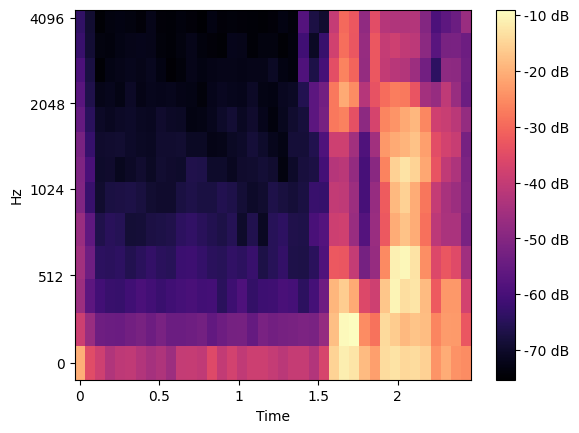

In [70]:
# Show mel spectrogram of the audio using librosa
melspec = librosa.feature.melspectrogram(y=y, sr=8000, n_mels=13, n_fft=512, hop_length=256)
logmelspec = librosa.power_to_db(melspec)
print('Shape of mel spectrogram:', logmelspec.shape)
plt.figure()
librosa.display.specshow(logmelspec, sr=8000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

## Shape of MCV recordings 

In [71]:
# I only have audio files under 25382872 in the path column

# Grabbing first 3 numbers in the file number
filtered_df.loc[:, 'file_number'] = filtered_df['path'].str.split('_').str[3].str.split('.').str[0].str[0:3].astype(int)

filtered_df_sampled = filtered_df[filtered_df['file_number'] < 252]

print('Shape of filtered dataframe:', filtered_df_sampled.shape)

# Randomly select 2000 audio files
filtered_df_sampled = filtered_df_sampled.sample(n=2000, random_state=42)

# Figure out the shape of the audio files
print('Shape of filtered dataframe:', filtered_df_sampled.shape)

Shape of filtered dataframe: (1046931, 16)
Shape of filtered dataframe: (2000, 16)


C:\Users\Jonah\AppData\Local\Temp\ipykernel_31412\1316946750.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'file_number'] = filtered_df['path'].str.split('_').str[3].str.split('.').str[0].str[0:3].astype(int)


In [72]:
print(MCV_dir)

C:/Users/Jonah/Documents/Datasets/MCV/MCV_data/en


In [73]:
min_samples = 1000000

# Find the minimum number of samples in the audio files
for i in range(filtered_df_sampled.shape[0]):
    y, sr = librosa.load(MCV_dir + '/clips/' + filtered_df_sampled.iloc[i]['path'], sr=8000)
    if len(y) < min_samples:
        min_samples = len(y)

print('Minimum number of samples:', min_samples)

Minimum number of samples: 10752


Since we know that each audio clip in the MCV is bigger than the audio clip of the wakeup word recordings, we don't have to do any sort of padding for the MCV clips.

Shape of mel spectrogram: (13, 39)


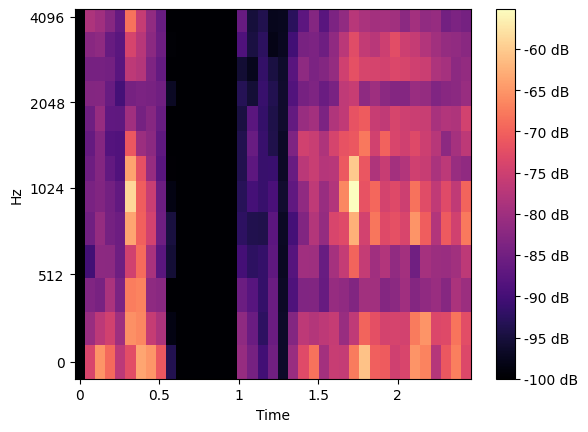

In [74]:
y, sr = librosa.load(MCV_dir + '/clips/' + filtered_df_sampled.iloc[0]['path'], sr=8000)
# Trim to minimum number of samples 9846
y = y[0:9846]
melspec = librosa.feature.melspectrogram(y=y, sr=8000, n_mels=13, n_fft=512, hop_length=256)
logmelspec = librosa.power_to_db(melspec)
print('Shape of mel spectrogram:', logmelspec.shape)
plt.figure()
librosa.display.specshow(logmelspec, sr=8000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [75]:
# Only keep the columns we need
filtered_df_sampled = filtered_df_sampled[['path', 'sentence', 'clip', 'file_number']]

In [76]:
print(os.getcwd())

c:\Users\Jonah\Documents\Code\pyprogs\VoiceAssistedFanController\wakeword\model


In [77]:
filtered_df_sampled.to_csv('../../my_data/filtered_df_sampled.csv', index=False)

# Create noise recordings for negative set

Going to split up my ambient_noise.wav file into 9846 sample chunks to both use as negative samples and as added noise to both the negative and positive set.

In [78]:
y, sr = librosa.load('../../my_data/ambient_noise.wav', sr=8000)

print('Number of samples in ambient noise file:', len(y))

Number of samples in ambient noise file: 2396300


In [79]:
import soundfile as sf

# Generating 200 numbers between 0 and 2396300 - 9846 to get the start of the audio file
random_starts = random.sample(range(0, 2396300 - 9846), 200)

# Generate 200 audio files with 9846 samples each
for i in range(200):
    temp = y[random_starts[i]:random_starts[i] + 9846]
    sf.write('../../my_data/noise_recordings/ambient_noise_' + str(i) + '.wav', temp, 8000)

# Create Dataset CSV

In [102]:
MCV_df = pd.read_csv('../../my_data/filtered_df_sampled.csv')
wakeup_dir = 'C:/Users/Jonah/Documents/Code/pyprogs/VoiceAssistedFanController/my_data/wakeup_recordings'
noise_dir = 'C:/Users/Jonah/Documents/Code/pyprogs/VoiceAssistedFanController/my_data/noise_recordings'

In [103]:
MCV_df.head()

,path,sentence,clip,file_number
0,common_voice_en_19743668.mp3,Each form elects two representatives to sit on...,common_voice_en_19743668.mp3,197
1,common_voice_en_20456047.mp3,Two palace aides were eventually convicted of ...,common_voice_en_20456047.mp3,204
2,common_voice_en_22911541.mp3,"Merestead, Saint Mark's Cemetery, and the Unit...",common_voice_en_22911541.mp3,229
3,common_voice_en_1625181.mp3,What is it like?,common_voice_en_1625181.mp3,162
4,common_voice_en_20490986.mp3,"These species are found in North America, with...",common_voice_en_20490986.mp3,204


In [104]:
df = MCV_df[['path']]

MCV_dir = 'C:/Users/Jonah/Documents/Datasets/MCV/MCV_data/en' + '/clips/'

# Add MCV_dir to path of each file
df.loc[:, 'path'] = MCV_dir + df['path']

In [105]:
noise_files = os.listdir(noise_dir)

for i in range(len(noise_files)):
    noise_files[i] = noise_dir + '/' + noise_files[i]

df_noise = pd.DataFrame(noise_files, columns=['path'])

# Save the dataframe to a csv file
df_noise.to_csv('../../my_data/noise.csv', index=False)
df = pd.concat([df, df_noise], ignore_index=True)
df['label'] = 0


In [107]:
wakeup_files = os.listdir(wakeup_dir)

for i in range(len(wakeup_files)):
    wakeup_files[i] = wakeup_dir + '/' + wakeup_files[i]

df_wakeup = pd.DataFrame(wakeup_files, columns=['path'])

df_wakeup['label'] = 1

# Duplicate the wakeup files 10 times
df_wakeup = pd.concat([df_wakeup] * 10, ignore_index=True)

df = pd.concat([df, df_wakeup], ignore_index=True)

In [108]:
df.shape

(3200, 2)

In [109]:
# Save the dataframe to a csv file
df.to_csv('../../my_data/df.csv', index=False)